In [0]:
%tensorflow_version 2.x

TensorFlow 2.x selected.


In [0]:
import tensorflow as tf
print(tf.__version__)

2.1.0-rc1


# Purpose 
Given an image differentiate between different plant types. This dataset gives you an opportunity to experiment with different image recognition techniques, as well to provide a place to cross-pollenate ideas.


In [0]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
import os
from PIL import Image
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from glob import glob
import cv2
import scipy.misc
from skimage import transform
from tqdm import tqdm

import warnings

warnings.filterwarnings("ignore")

In [0]:
data_directory = 'gdrive/My Drive/Colab Notebooks'

# Data Description

You are provided with a training set and a test set of images of plant seedlings at various stages of grown. Each image has a filename that is its unique id. 

The dataset comprises 12 plant species. The goal of the competition is to create a classifier capable of determining a plant's species from a photo. 

The list of species is as follows: 
 Black-grass 

 Charlock 

 Cleavers 

 Common Chickweed 

 Common wheat 

 Fat Hen 

 Loose Silky-bent 

 Maize 

 Scentless Mayweed 

 Shepherds Purse 

 Small-flowered Cranesbill 

 Sugar beet

In [0]:
#convertering list of training data paths to df
train_directory = 'gdrive/My Drive/Colab Notebooks/train/'
species = ['Black-grass', 'Charlock', 'Cleavers', 'Common Chickweed', 'Common wheat', 'Fat Hen',
          'Loose Silky-bent', 'Maize','Scentless Mayweed', 'Shepherds Purse',
          'Small-flowered Cranesbill', 'Sugar beet']

In [0]:
# Organize training files into DataFrame
train_data = []
for species_id, sp in enumerate(species):
    for file in os.listdir(os.path.join(train_directory, sp)):
        train_data.append(['train/{}/{}'.format(sp, file), species_id, sp])
        
train = pd.DataFrame(train_data, columns=['File', 'SpeciesId','Species'])

In [0]:
# checking the first few rows of train dataframe
train.head()

,File,SpeciesId,Species
0,train/Black-grass/0260cffa8.png,0,Black-grass
1,train/Black-grass/078eae073.png,0,Black-grass
2,train/Black-grass/0ace21089.png,0,Black-grass
3,train/Black-grass/0bb75ded8.png,0,Black-grass
4,train/Black-grass/0c67c3fc3.png,0,Black-grass


In [0]:
#checking the shape of train dataset
train.shape

(4750, 3)

In [0]:
# Randomize the order of training set
SEED = 42
train = train.sample(frac=1, random_state=SEED) 
train.index = np.arange(len(train)) # Reset indices
train.head()

,File,SpeciesId,Species
0,train/Shepherds Purse/c9457398b.png,9,Shepherds Purse
1,train/Common Chickweed/2de5e6eaf.png,3,Common Chickweed
2,train/Charlock/b8421d027.png,1,Charlock
3,train/Fat Hen/91e05c100.png,5,Fat Hen
4,train/Common wheat/a25f5ccb5.png,4,Common wheat


In [0]:
train.tail()

,File,SpeciesId,Species
4745,train/Sugar beet/2cb41be46.png,11,Sugar beet
4746,train/Charlock/78fc2ef58.png,1,Charlock
4747,train/Maize/cf7b09a39.png,7,Maize
4748,train/Shepherds Purse/9617b5025.png,9,Shepherds Purse
4749,train/Cleavers/b07aeb162.png,2,Cleavers


**Plotting the train image set**

In [0]:
from mpl_toolkits.axes_grid1 import ImageGrid
from keras.preprocessing import image

In [0]:
def read_img(filepath, size):
    img = image.load_img(os.path.join(data_directory, filepath), target_size=size)
    img = image.img_to_array(img)
    return img

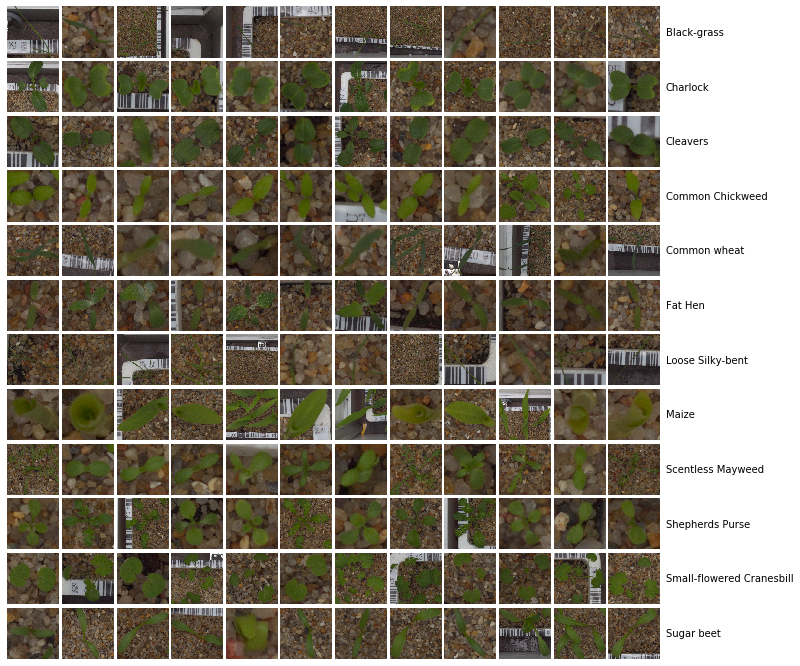

In [0]:

NUM_CATEGORIES = len(species)
fig = plt.figure(1, figsize=(NUM_CATEGORIES, NUM_CATEGORIES))
grid = ImageGrid(fig, 111, nrows_ncols=(NUM_CATEGORIES, NUM_CATEGORIES), axes_pad=0.05)
i = 0
for category_id, category in enumerate(species):
    for filepath in train[train['Species'] == category]['File'].values[:NUM_CATEGORIES]:
        ax = grid[i]
        img = read_img(filepath, (224, 224))
        ax.imshow(img / 255.)
        ax.axis('off')
        if i % NUM_CATEGORIES == NUM_CATEGORIES - 1:
            ax.text(250, 112, filepath.split('/')[1], verticalalignment='center')
        i += 1
plt.show();

**Getting the data and resizing the image**

In [0]:
IMAGE_SIZE = 66

#creating an empty array of zeros to store the image pixels
X_train = np.zeros((train.shape[0], IMAGE_SIZE, IMAGE_SIZE, 3))

In [0]:
# Read each image in the train set. And for each image resize the values and add it into X_train dataset
dim = (66,66)
for i, file in tqdm(enumerate(train['File'].values)):
    image = cv2.imread(os.path.join(data_directory, file))
    X_train[i] = cv2.resize(image.copy(), (66, 66), interpolation=cv2.INTER_AREA)


4750it [41:44,  1.97it/s]


In [0]:
# Normalize the data
X_train = X_train / 255.

**Converting the Labels into numbers:**


*   The labels are strings and these are hard to process. So we'll convert these labels into a binary classification.
*   The classification can be represented by an array of 12 numbers which will follow the condition:

    0 if the species is not detected.
    
    1 if the  species is detected

*   Example: If Blackgrass is detected, the array will be = [1,0,0,0,0,0,0,0,0,0,0,0]

In [0]:
Y_train = train['SpeciesId'].values
from keras.utils import to_categorical

Y_train = tf.keras.utils.to_categorical(Y_train, num_classes=12)

Using TensorFlow backend.


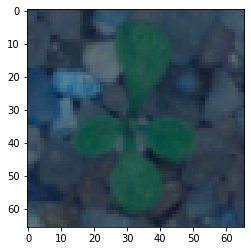

In [0]:
plt.imshow(X_train[0])

### Since the file is containing huge data, each time loading/reading/preprocessing images were taking quality amount of time. To reduce the processing time, after the preprocessing we created a pickle file and stored the images.

### So the image read and model building takes less time

In [0]:
import pickle

In [0]:

pickle_out = open("gdrive/My Drive/Colab Notebooks/x_train.pickle","wb")
pickle.dump(X_train,pickle_out)
pickle_out.close()

pickle_out = open("gdrive/My Drive/Colab Notebooks/Y_train.pickle","wb")
pickle.dump(Y_train,pickle_out)
pickle_out.close()

In [0]:
pickle_in = open("gdrive/My Drive/Colab Notebooks/x_train.pickle","rb")
X_train = pickle.load(pickle_in) 
print(X_train.shape)
pickle_in.close()

(4750, 66, 66, 3)


In [0]:
pickle_in = open("gdrive/My Drive/Colab Notebooks/Y_train.pickle","rb")
Y_train = pickle.load(pickle_in) 
print(Y_train.shape)
pickle_in.close()

(4750, 12)


**splitting the dataset:**

We need to split the training set for validation.

In [0]:
X_Train,X_Val,y_Train,y_Val = train_test_split(X_train,Y_train,test_size=0.3,random_state=77,stratify=Y_train)

In [0]:
X_Train.shape

(3325, 66, 66, 3)

## Defining the Convolutional Neural Network:

This model has 4 convolution layers.

This model has 3 fully connected layers.

In [0]:
np.random.seed(77)

model = tf.keras.Sequential()

model.add(tf.keras.layers.Conv2D(filters=32, kernel_size=(5, 5), input_shape=(66, 66, 3), activation='relu'))
model.add(tf.keras.layers.BatchNormalization(axis=3))
model.add(tf.keras.layers.Conv2D(filters=32, kernel_size=(5, 5), activation='relu'))
model.add(tf.keras.layers.MaxPooling2D((2, 2)))
model.add(tf.keras.layers.BatchNormalization(axis=3))
model.add(tf.keras.layers.Dropout(0.1))

model.add(tf.keras.layers.Conv2D(filters=32, kernel_size=(5, 5), activation='relu'))
model.add(tf.keras.layers.BatchNormalization(axis=3))
model.add(tf.keras.layers.Conv2D(filters=32, kernel_size=(5, 5), activation='relu'))
model.add(tf.keras.layers.MaxPooling2D((2, 2)))
model.add(tf.keras.layers.BatchNormalization(axis=3))
model.add(tf.keras.layers.Dropout(0.1))

model.add(tf.keras.layers.Conv2D(filters=64, kernel_size=(5, 5), activation='relu'))
model.add(tf.keras.layers.BatchNormalization(axis=3))
model.add(tf.keras.layers.Conv2D(filters=64, kernel_size=(5, 5), activation='relu'))
model.add(tf.keras.layers.MaxPooling2D((2, 2)))
model.add(tf.keras.layers.BatchNormalization(axis=3))
model.add(tf.keras.layers.Dropout(0.1))

model.add(tf.keras.layers.Flatten())

model.add(tf.keras.layers.Dense(128, activation='relu'))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.Dropout(0.5))

model.add(tf.keras.layers.Dense(128, activation='relu'))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.Dropout(0.5))

model.add(tf.keras.layers.Dense(12, activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 62, 62, 32)        2432      
_________________________________________________________________
batch_normalization (BatchNo (None, 62, 62, 32)        128       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 58, 58, 32)        25632     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 29, 29, 32)        0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 29, 29, 32)        128       
_________________________________________________________________
dropout (Dropout)            (None, 29, 29, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 25, 25, 32)        2

### Preventing Overfitting:

To prevent overfitting, we need to create a function that can randomly change image characterisitics during fitting.

In [0]:
generator = tf.keras.preprocessing.image.ImageDataGenerator(rotation_range = 180,zoom_range = 0.1,
             width_shift_range = 0.1,height_shift_range = 0.1,
             horizontal_flip = True,vertical_flip = True)
generator.fit(X_Train)

In [0]:
# Fits the model on batches with real-time data augmentation
hist = model.fit_generator(generator.flow(X_Train, y_Train, batch_size=32),
                   steps_per_epoch=X_Train.shape[0] // 32,
                   epochs=30,
                   verbose=2,
                   validation_data=(X_Val, y_Val))

Instructions for updating:
Please use Model.fit, which supports generators.
  ...
    to  
  ['...']
Train for 103 steps, validate on 1425 samples
Epoch 1/30
103/103 - 113s - loss: 3.0440 - accuracy: 0.1597 - val_loss: 2.6925 - val_accuracy: 0.1502
Epoch 2/30
103/103 - 111s - loss: 2.2231 - accuracy: 0.3116 - val_loss: 6.8751 - val_accuracy: 0.1375
Epoch 3/30
103/103 - 110s - loss: 1.9028 - accuracy: 0.3775 - val_loss: 4.3569 - val_accuracy: 0.1396
Epoch 4/30
103/103 - 109s - loss: 1.7258 - accuracy: 0.4261 - val_loss: 5.3104 - val_accuracy: 0.1418
Epoch 5/30
103/103 - 109s - loss: 1.5439 - accuracy: 0.4783 - val_loss: 2.3679 - val_accuracy: 0.3354
Epoch 6/30
103/103 - 109s - loss: 1.4046 - accuracy: 0.5238 - val_loss: 4.2505 - val_accuracy: 0.1375
Epoch 7/30
103/103 - 109s - loss: 1.3477 - accuracy: 0.5500 - val_loss: 1.0936 - val_accuracy: 0.6288
Epoch 8/30
103/103 - 109s - loss: 1.2410 - accuracy: 0.5742 - val_loss: 1.6985 - val_accuracy: 0.4449
Epoch 9/30
103/103 - 109s - loss: 1.1

In [0]:
# Fits the model on batches with real-time data augmentation
hist = model.fit_generator(generator.flow(X_Train, y_Train, batch_size=32),
                   steps_per_epoch=X_Train.shape[0] // 32,
                   epochs=10,
                   verbose=1,
                   validation_data=(X_Val, y_Val))

  ...
    to  
  ['...']
Train for 103 steps, validate on 1425 samples
Epoch 1/10
103/103 [==============================] - 105s 1s/step - loss: 0.4731 - accuracy: 0.8500 - val_loss: 0.9815 - val_accuracy: 0.6702
Epoch 2/10
103/103 [==============================] - 105s 1s/step - loss: 0.4384 - accuracy: 0.8479 - val_loss: 0.8516 - val_accuracy: 0.7368
Epoch 3/10
103/103 [==============================] - 107s 1s/step - loss: 0.4093 - accuracy: 0.8524 - val_loss: 0.4996 - val_accuracy: 0.8379
Epoch 4/10
103/103 [==============================] - 107s 1s/step - loss: 0.4210 - accuracy: 0.8473 - val_loss: 0.5175 - val_accuracy: 0.8337
Epoch 5/10
103/103 [==============================] - 106s 1s/step - loss: 0.4091 - accuracy: 0.8585 - val_loss: 0.4015 - val_accuracy: 0.8653
Epoch 6/10
103/103 [==============================] - 107s 1s/step - loss: 0.3882 - accuracy: 0.8652 - val_loss: 0.5739 - val_accuracy: 0.7818
Epoch 7/10
103/103 [==============================] - 107s 1s/step - lo

In [0]:
# Printing the loss and accuracy of the model
final_loss, final_accuracy = model.evaluate(X_Val, y_Val)
print('Final Loss: {}, Final Accuracy: {}'.format(final_loss, final_accuracy))

1425/1425 [==============================] - 9s 6ms/sample - loss: 0.6104 - accuracy: 0.8204
Final Loss: 0.6104474916792753, Final Accuracy: 0.8203508853912354


### Confusion Matrix:

The confusion matrix is one of the best ways to analyse the errors in the model.

It gives the exact number of correct and incorrect predictions

In [0]:
from sklearn.metrics import confusion_matrix

# PREDICTIONS
y_pred = model.predict(X_Val)
y_class = np.argmax(y_pred, axis = 1) 
y_check = np.argmax(y_Val, axis = 1) 

cmatrix = confusion_matrix(y_check, y_class)

print(cmatrix)

[[ 14   0   0   0   1   6  57   1   0   0   0   0]
 [  0 108   0   0   0   1   0   0   0   1   2   5]
 [  0  29  10   1   2  27   0   0  15   1   1   0]
 [  0   0   0 172   0   1   0   2   2   4   1   1]
 [  7   0   0   0  43   4   1  10   0   0   0   1]
 [  1   0   0   1   0 138   0   1   1   0   0   1]
 [  5   0   0   0   0   4 187   0   0   0   0   0]
 [  0   0   0   0   0   0   1  59   2   0   0   4]
 [  0   0   0   1   0   4   3   2 137   6   0   2]
 [  0   0   0   1   0   4   0   0   2  62   0   0]
 [  0   1   0   0   0  15   1   1   0   0 131   0]
 [  0   0   0   1   2   2   0   1   0   2   0 108]]


In [0]:
 import numpy as np 
 from sklearn.metrics import classification_report 

report = classification_report(np.argmax(y_pred,axis=1),np.argmax(y_Val,axis=1)) 
print('Final Validation Results') 
print(report)

Final Validation Results
              precision    recall  f1-score   support

           0       0.18      0.52      0.26        27
           1       0.92      0.78      0.85       138
           2       0.12      1.00      0.21        10
           3       0.94      0.97      0.96       177
           4       0.65      0.90      0.75        48
           5       0.97      0.67      0.79       206
           6       0.95      0.75      0.84       250
           7       0.89      0.77      0.83        77
           8       0.88      0.86      0.87       159
           9       0.90      0.82      0.86        76
          10       0.88      0.97      0.92       135
          11       0.93      0.89      0.91       122

    accuracy                           0.82      1425
   macro avg       0.77      0.82      0.75      1425
weighted avg       0.90      0.82      0.85      1425



### It seems as though the CNN has trouble distinguishing between black-grass and cleavers images. 

# Conclusion

1. We loaded the train dataset folder and read the images and assigned the species for each image.

2. We plotted few images to see how it looks like and resized the images so that CNN can process.

3. We build a sequential neural network model and trained them after augumentation of images,we used 30 epochs and batch size of 32.

4. We validated our model against the validation data set.

5. Our model performed fairly well and achieved 82% accuracy.

#### We see that the accuracy was improving with more number of hidden layers and filters. Also during the multiple experiments, the batch size and epochs also help to improve the accuracy. Since its taking quite lot of time to train the model, we didnt try with more number of hidden layers/filters.